<table border=0px>
<tr>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5a/HuffPost.svg/320px-HuffPost.svg.png">
</td>
<td>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/cf/Flag_of_Canada.svg/320px-Flag_of_Canada.svg.png">
</td>
</tr>
</table>

# Analyse des sources de l'édition canadienne du *Huff Post* (2011-2016) en 6 étapes faciles
<hr>

<h3 style="background:teal;color:white;padding:5px">Étape 1 - Initialisation de notre *notebook* et lecture du fichier CSV contenant nos données</h3>

In [1]:
import csv, re, random
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats, integrate
pd.set_option('display.max_colwidth', -1)
pd.options.display.max_rows = 25
pd.options.mode.chained_assignment = None
%matplotlib inline

On lit notre fichier CSV de base, puis on crée une variable `edition` pour identifier le pays sur lequel on va travailler. La variable `huff` ne contient que les **265&nbsp;153 articles** de l'édition du pays auquel on s'intéresse ici.

In [2]:
huff = pd.read_csv("scraping-nettoye.csv", low_memory=False)
edition = "Canada"
huff = huff[huff.pays == edition]
huff.shape

(265153, 13)

Le but de cet exercice étant d'identifier le taux d'originalité du *HuffPost*, on va créer trois variables.

- `HP_oui` contiendra la proportion d'articles qui sont originaux (signés par des employés du *HuffPost* ou des pigistes).
- `HP_non` contiendra la proportion d'articles qui ne sont pas originaux (repris d'agences externes ou d'autres médias).
- `HP_inconnu` contiendra la proportion d'articles dont on ne peut pas établir la provenance.

La somme de ces trois variables équivaudra à 100. On s'en servira pour faire un graphique en pointes de tarte (camembert) à la fin.

In [3]:
HP_oui = 0
HP_non = 0
HP_inconnu = 0

<h3 style="background:teal;color:white;padding:5px">Étape 2 - Filtrer les balises <i>meta</i></h3>

<hr>
Cette étape n'est pas nécessaire, car tous les articles de cette éditions ont, pour nom dans leurs balises `meta`, le nom du *Huffington Post*.

<h3 style="background:teal;color:white;padding:5px">Étape 3 - Identification des articles dont les signataires sont inconnus</h3>

In [4]:
huff.byline.value_counts()

? CBC                                                           66400
By The Canadian Press CP                                        41958
By The Associated Press CP                                      13849
? The Huffington Post Canada                                    10052
? www.parentdish.ca                                             2120 
? The Huffington Post B.C.                                      2075 
? CP                                                            1846 
By CBC CBC                                                      1805 
By Neil Davidson, The Canadian Press CP                         1760 
? The Huffington Post Alberta                                   1645 
? www.stylelist.ca                                              1629 
By Malcolm Morrison, The Canadian Press CP                      1582 
                                                                ...  
By Joan Bryden and Jordan Press CP                              1    
By Mae Anderson And 

Un certain nombre d'auteurs sont inconnus («&nbsp;?&nbsp;» ou «&nbsp;?&nbsp;?&nbsp;»).<br>
Ceux marqués d'un seul point d'interrogation seront placés dans la variable `inconnu1`, ceux qui sont marqués de deux points d'interrogation dans la variable `inconnu2`.<br>
Ils représentent à peine **0,5%** du total des articles de cette édition du *Huffington&nbsp;Post*.

In [5]:
inconnus1 = huff.byline == "? "
inconnus2 = huff.byline == "? ?"
HP_inconnu = huff[inconnus1].pays.count() + huff[inconnus2].pays.count()
HP_inconnu, (HP_inconnu/len(huff))*100

(1394, 0.52573419874562988)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 4 - Identification des articles originaux au <i>HuffPost</i></h3>

Examinons maintenant les articles dont la signature contient certaines chaînes de caractères qui correspondent au *Huffington Post* (dans différentes langues, fautes de frappe incluses), ou à sa compagnie-mère, AOL. On va baptiser ce sous-ensemble `signéHP`.

In [6]:
signeHP = huff.byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[signeHP].shape

(39319, 13)

In [7]:
huff[signeHP].byline.value_counts(), huff[signeHP].byline.value_counts().count()

(? The Huffington Post Canada                                                    10052
 ? The Huffington Post B.C.                                                      2075 
 ? The Huffington Post Alberta                                                   1645 
 ByDaniel Tencer The Huffington Post Canada                                      1562 
 ByJesse Ferreras The Huffington Post Canada                                     1562 
 ByIsabelle Khoo The Huffington Post Canada                                      1491 
 ByArti Patel The Huffington Post Canada                                         1353 
 ByMadelyn Chung The Huffington Post Canada                                      1108 
 ByJoy D'Souza The Huffington Post Canada                                        1056 
 ByMonika Markovinovic The Huffington Post Canada                                969  
 ByChloe Tejada The Huffington Post Canada                                       865  
 ByZi-Ann Lum The Huffington Post Canada   

Le *Huffington Post* est nommé, d'une façon ou d'une autre, dans ces quelque **39&nbsp;319 articles** signés par **1&nbsp;061 signataires différents**.<br>
Cela représente à peine le sixième de l'ensemble des articles publiés par l'édition canadienne du *HuffPost* dans la période étudiée.

In [8]:
HP_oui = huff[signeHP].pays.count()
HP_oui, (HP_oui/len(huff))*100

(39319, 14.828796958737032)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 5 - Identification des articles <u>extérieurs</u> au <i>HuffPost</i></h3>

On va donc faire la même opération, mais pour tous les postes dans lesquels **on ne trouve pas** les chaînes de caractères permettant d'identifier le *Huffington&nbsp;Post* dans différentes langues. On va créer une nouvelle variable qu'on va appeler `NONsignéHP`.

In [9]:
NONsigneHP = ~huff.byline.str.contains("[H,h][U,u,f][F,f][i,F,f,P,p]|ハフ|ポスト|허핑턴|허프|[A,a][O,o][L,l]",na=False)
huff[NONsigneHP].shape

(225834, 13)

Qui sont ces auteurs qui ne font pas partie de l'équipe du *HuffPost*?

In [10]:
huff[NONsigneHP].byline.value_counts(), huff[NONsigneHP].byline.value_counts().count()

(? CBC                                                                 66400
 By The Canadian Press CP                                              41958
 By The Associated Press CP                                            13849
 ? www.parentdish.ca                                                   2120 
 ? CP                                                                  1846 
 By CBC CBC                                                            1805 
 By Neil Davidson, The Canadian Press CP                               1760 
 ? www.stylelist.ca                                                    1629 
 By Malcolm Morrison, The Canadian Press CP                            1582 
 ?                                                                     1256 
 By Ross Marowits, The Canadian Press CP                               1193 
 By Stephen Whyno, The Canadian Press CP                               1173 
                                                                       ...  

Des 6&nbsp;823 signataires ci-dessus, par contre, on trouve un certain nombre d'«&nbsp;employés fantôme&nbsp;».

C'est le cas d'Althia Raj, qui est [clairement un employée du *Huff Post*](http://www.huffingtonpost.ca/author/althia-raj/).

Nous avons identifié au moins 1&nbsp;490 articles signés par ces «&nbsp;employés fantôme&nbsp;». Il faut donc les ajouter à notre variable `HP_oui`.

In [11]:
HP_oui = huff[signeHP].pays.count() + 1490
HP_oui, (HP_oui/len(huff))*100

(40809, 15.39073666901751)

Il nous reste donc à calculer le pourcentage des articles signés par des auteurs externes.

Il faut ici soustraire de notre variable `NONsignéHP` les articles contenus dans les deux variables `inconnu1` et `inconnu2`, ainsi que les auteurs fantômes qu'on a identifiés ci-dessus.

In [12]:
HP_non = huff[NONsigneHP].pays.count() - (huff[inconnus1].pays.count() + huff[inconnus2].pays.count()) + (len(huff) - len(huff)) - 1490
HP_non, (HP_non/len(huff))*100

(222950, 84.083529132236862)

On a désormais tout ce qu'il nous faut pour faire le camembert évoqué plus haut.

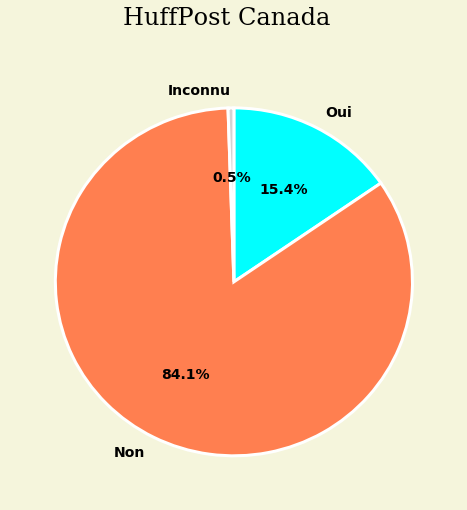

In [13]:
camembert = pd.Series([HP_oui,HP_non,HP_inconnu], index=["Oui","Non","Inconnu"],name="")
titre = plt.figure(facecolor="beige")
titre.suptitle("HuffPost Canada", fontsize=24, fontweight="light", fontname="Serif")
camembert.plot.pie(colors=["aqua","coral","lightgrey"],
                   wedgeprops={"linewidth":3,"edgecolor":"white"},
                   textprops={"weight":"bold","fontsize":14},
                   counterclock=False,
                   startangle=90,
                   autopct="%1.1f%%",
                   figsize=(8,8)
)

<hr>
<h3 style="background:teal;color:white;padding:5px">Étape 6 - Dernier exercice&nbsp;: les étiquettes (<i>tags</i>)</h3>

Chaque article du *Huffington Post* est généralement accompagné d'une dizaine de marqueurs, ou d'étiquettes (*tags* en anglais). Voici ceux qui sont le plus fréquemment utilisés par l'édition canadienne.

Les étiquettes les plus utilisées font référence aux sources des articles du *HuffPost Canada*:

- 44% des articles sont repris en tout ou en partie de la *Canadian Press*
- 24% des articles sont repris en tout ou en partie de la *Canadian Broadcasting Corporation*

In [14]:
etiquettes = huff.set_index('pays').tags.str.split(',', expand=True).stack().rename(columns={0:'tag'}).reset_index(drop=True)
etiquettes.value_counts(dropna=False)

cp                                118694
cbc                               63729 
video                             52943 
vancouver                         3387  
business video                    2898  
calgary                           2507  
style video                       1800  
politics video                    1681  
justin trudeau                    1676  
edmonton                          1673  
alberta crime                     1643  
Alberta Politics                  1636  
                                  ...   
lady gaga harpers bazaar          1     
dylann roof shooting              1     
don valley flood                  1     
bc health care workers            1     
it gets better dalton mcguinty    1     
canada and births                 1     
Assiniboine Zoo polar bears       1     
lawful access bill                1     
omega-3 smoking study             1     
Canada 2012 games                 1     
weed banking colorado             1     
Coachella kriste